!pip install python_speech_features

In [1]:
from os import listdir
from os.path import isdir, join

# os: listdir- count the directory files.
# isdir: to check for confirmation of existence of file.
# join to make the successful path connection 

In [2]:
from librosa import load
# load wav file

In [3]:
import random
# so that the random files are divided in train, text, validation set.

In [4]:
import numpy as np
import matplotlib.pyplot as plt
# make the mfcc graph

In [5]:
import python_speech_features
# used in feature ecxtraction

In [6]:
from tensorflow.keras import layers, models
#CNN model.
import numpy as np

In [7]:
# Dataset path and view possible targets
dataset_path = 'H://AI//capstone_project//NewMethod//mini_speech_commands'
i=0
dict={}
for name in listdir(dataset_path):
    if isdir(join(dataset_path, name)):
        dict[i]=name
        i+=1

In [8]:
# Create list of an all targets list
all_targets = [name for name in listdir(dataset_path) if isdir(join(dataset_path, name))]
print(all_targets)

['backward', 'bed', 'bird', 'cat', 'dog', 'down', 'eight', 'five', 'follow', 'forward', 'four', 'go', 'happy', 'house', 'left', 'nine', 'no', 'off', 'one', 'right', 'seven', 'six', 'stop', 'three', 'two', 'up', 'visual', 'wow', 'yes', 'zero']


In [9]:
# See how many files are in each
num_samples = 0
for target in all_targets:
    print(len(listdir(join(dataset_path, target))))
    num_samples += len(listdir(join(dataset_path, target)))
print('Total samples:', num_samples)

1020
1060
1026
1040
1020
1000
1003
1004
1073
1029
1007
1000
1014
1013
1000
1042
1000
1029
1000
1000
1053
1010
1000
1028
1022
1000
1056
1022
1000
1000
Total samples: 30571


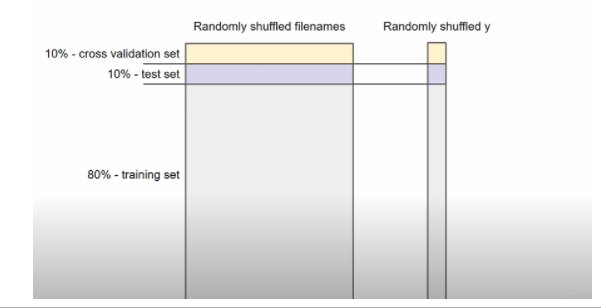

In [10]:
# Settings
target_list = all_targets
feature_sets_file = 'all_targets_mfcc_sets.npz'
perc_keep_samples = 1.0 # 1.0 is keep all samples
val_ratio = 0.1
test_ratio = 0.1
sample_rate = 8000
num_mfcc = 16
len_mfcc = 16

In [11]:
# Create list of filenames along with ground truth vector (y)- original index.
filenames = []
y = []
for index, target in enumerate(target_list):
    #print(join(dataset_path, target))
    filenames.append(listdir(join(dataset_path, target)))
    y.append(np.ones(len(filenames[index])) * index)


# Check ground truth Y vector
for item in y:
    print(len(item))

In [12]:
# Flatten filename and y vectors
filenames = [item for sublist in filenames for item in sublist]
y = [item for sublist in y for item in sublist]

In [13]:
# Associate filenames with true output and shuffle
filenames_y = list(zip(filenames, y))
random.shuffle(filenames_y)
filenames, y = zip(*filenames_y)

In [14]:
# Only keep the specified number of samples (shorter extraction/training)
print(len(filenames))
filenames = filenames[:int(len(filenames) * perc_keep_samples)]
print(len(filenames))

30571
30571


MFCC: Transforming audio into Mel Frequency Cepstral Coefficients.
 
 To find MFCC take a small time in the audio and find the fast FT so that we get the freq of that time slice. Then apply the filters to that fast fourier transform spectrum. The filters are linearly spaced below 1KHz and lograthmically spaced above 1KHz. Then sum up the power found in each slice of filter to get a number representig the energy under that fitler. 
 
 Ususally MFCC uses 26 filters for voice.Compute the log of each filter in the vector and calculate the dct of each bank energies.At end we get 26 MFCC(if the initial vectors taken is 26).
 
 For speech we dont walt the 0 element and all the elements after element 13 as after 13 it is usually noise 
    
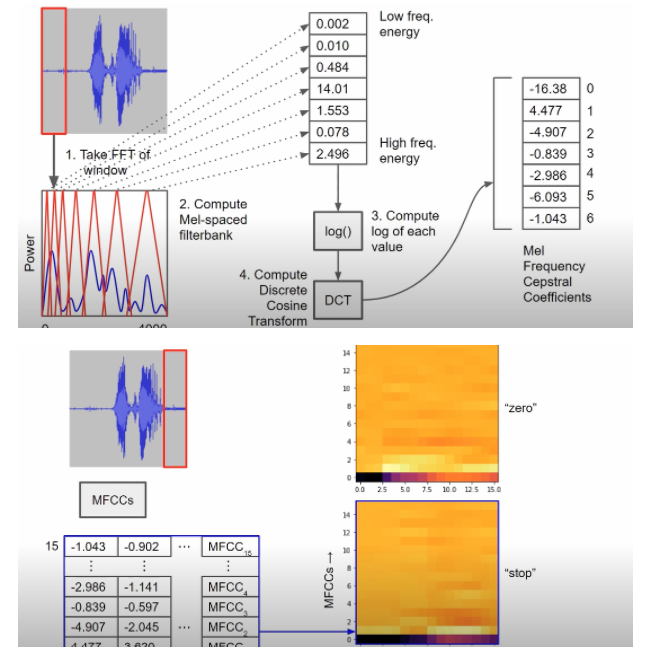

In [15]:
# Calculate length of validation and test set sizes
val_set_size = int(len(filenames) * val_ratio)
test_set_size = int(len(filenames) * test_ratio)

In [16]:
# Break dataset apart into train, validation, and test sets
filenames_val = filenames[:val_set_size]
filenames_test = filenames[val_set_size:(val_set_size + test_set_size)]
filenames_train = filenames[(val_set_size + test_set_size):]

In [17]:
# Break y apart into train, validation, and test sets
y_orig_val = y[:val_set_size]
y_orig_test = y[val_set_size:(val_set_size + test_set_size)]
y_orig_train = y[(val_set_size + test_set_size):]

In [18]:
print("***************Training****************")
print("training: ",len(filenames_train))
print("testing: ",len(filenames_test))
print("validation: ", len(filenames_val))

***************Training****************
training:  24457
testing:  3057
validation:  3057


In [19]:
# Function: Create MFCC from given path
def calc_mfcc(path):
    
    # Load wavefile and resample it at 8000Hz
    signal, fs = load(path, sr=sample_rate)
    
    # Create MFCCs from sound clip
    #create set of MFCC from sound clip
    
    # no of MFCC is low , 
    # therefore winlen is widen form 50 millisec to 256millisec, 
    # increase the distance between windows to 50 milli second.,
    # taking the first 16 mfcc,
    # no of filters: 26,
    #  FFT (fast fourier transform ) size: 2048( high becoz no of window are low.)
    # preemph, ceplifter – apply preemphasis filter, liftering(here, disabled)
    # winfunc – the analysis window to apply to each frame, prevent fft to produce unnecessary information
    mfccs = python_speech_features.base.mfcc(signal, 
                                            samplerate=8000,
                                            winlen=0.256,
                                            winstep=0.050,
                                            numcep=num_mfcc,
                                            nfilt=26,
                                            nfft=2048,
                                            preemph=0.0,
                                            ceplifter=0,
                                            appendEnergy=False,
                                            winfunc=np.hanning)
    return mfccs.transpose()

In [20]:
# TEST: Construct test set by computing MFCC of each WAV file
prob_cnt = 0
x_test = []
y_test = []
for index, filename in enumerate(filenames_train):
    
    # Stop after 500
    if index >= 500:
        break
    
    # Create path from given filename and target item
    path = join(dataset_path, target_list[int(y_orig_train[index])], 
                filename)
    
    # Create MFCCs
    mfccs = calc_mfcc(path)
    
    if mfccs.shape[1] <= len_mfcc:
        x_test.append(mfccs)
        y_test.append(y_orig_train[index])
    else:
        print('Dropped:', index, mfccs.shape)
        prob_cnt += 1

In [21]:
y_test

[1.0,
 21.0,
 21.0,
 20.0,
 12.0,
 21.0,
 17.0,
 1.0,
 18.0,
 17.0,
 24.0,
 4.0,
 25.0,
 7.0,
 18.0,
 11.0,
 7.0,
 0.0,
 5.0,
 15.0,
 3.0,
 26.0,
 6.0,
 28.0,
 2.0,
 18.0,
 13.0,
 13.0,
 8.0,
 0.0,
 24.0,
 11.0,
 29.0,
 0.0,
 17.0,
 22.0,
 3.0,
 8.0,
 13.0,
 15.0,
 27.0,
 2.0,
 7.0,
 11.0,
 2.0,
 5.0,
 3.0,
 24.0,
 27.0,
 29.0,
 16.0,
 17.0,
 9.0,
 13.0,
 9.0,
 19.0,
 6.0,
 4.0,
 2.0,
 2.0,
 14.0,
 27.0,
 13.0,
 7.0,
 8.0,
 10.0,
 6.0,
 3.0,
 18.0,
 24.0,
 10.0,
 1.0,
 26.0,
 17.0,
 8.0,
 15.0,
 17.0,
 5.0,
 25.0,
 21.0,
 26.0,
 26.0,
 28.0,
 5.0,
 1.0,
 3.0,
 4.0,
 7.0,
 3.0,
 17.0,
 6.0,
 3.0,
 6.0,
 28.0,
 17.0,
 4.0,
 4.0,
 21.0,
 5.0,
 11.0,
 18.0,
 13.0,
 7.0,
 15.0,
 0.0,
 19.0,
 9.0,
 29.0,
 9.0,
 20.0,
 7.0,
 1.0,
 7.0,
 12.0,
 27.0,
 14.0,
 20.0,
 17.0,
 24.0,
 17.0,
 21.0,
 26.0,
 28.0,
 5.0,
 22.0,
 21.0,
 13.0,
 27.0,
 16.0,
 29.0,
 28.0,
 17.0,
 27.0,
 6.0,
 7.0,
 23.0,
 4.0,
 15.0,
 21.0,
 27.0,
 28.0,
 19.0,
 5.0,
 0.0,
 20.0,
 10.0,
 29.0,
 21.0,
 10.0,
 3.0,
 20.0,
 2

In [22]:
print('% of problematic samples:', prob_cnt / 500)

% of problematic samples: 0.0


five


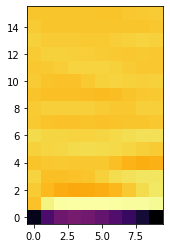

In [23]:
# TEST: Test shorter MFCC
#!pip install playsound
#from playsound import playsound


# to draw mfcc graph od word on index 13
idx = 13

# Create path from given filename and target item
path = join(dataset_path, target_list[int(y_orig_train[idx])], 
            filenames_train[idx])

# Create MFCCs
mfccs = calc_mfcc(path)
#print("MFCCs:", mfccs)

# Plot MFCC
fig = plt.figure()
plt.imshow(mfccs, cmap='inferno', origin='lower')

# TEST: Play problem sounds
print(target_list[int(y_orig_train[idx])])
#playsound(path)

In [24]:
# Function: Create MFCCs, keeping only ones of desired length
def extract_features(in_files, in_y):
    prob_cnt = 0
    out_x = []
    out_y = []
        
    for index, filename in enumerate(in_files):
    
        # Create path from given filename and target item
        path = join(dataset_path, target_list[int(in_y[index])], 
                    filename)
        
        # Check to make sure we're reading a .wav file
        if not path.endswith('.wav'):
            continue

        # Create MFCCs
        mfccs = calc_mfcc(path)

        # Only keep MFCCs with given length
        if mfccs.shape[1] == len_mfcc:
            out_x.append(mfccs)
            out_y.append(in_y[index])
        else:
            print('Dropped:', index, mfccs.shape)
            prob_cnt += 1
            
    return out_x, out_y, prob_cnt

In [25]:
# Create train, validation, and test sets
x_train, y_train, prob = extract_features(filenames_train, y_orig_train)
print('Removed percentage:', prob / len(y_orig_train))


Dropped: 0 (16, 15)
Dropped: 1 (16, 10)
Dropped: 2 (16, 12)
Dropped: 3 (16, 10)
Dropped: 5 (16, 12)
Dropped: 8 (16, 9)
Dropped: 10 (16, 6)
Dropped: 13 (16, 10)
Dropped: 14 (16, 10)
Dropped: 15 (16, 13)
Dropped: 16 (16, 9)
Dropped: 19 (16, 11)
Dropped: 22 (16, 5)
Dropped: 25 (16, 10)
Dropped: 30 (16, 8)
Dropped: 31 (16, 7)
Dropped: 32 (16, 10)
Dropped: 39 (16, 11)
Dropped: 42 (16, 11)
Dropped: 47 (16, 7)
Dropped: 49 (16, 8)
Dropped: 56 (16, 6)
Dropped: 63 (16, 7)
Dropped: 65 (16, 10)
Dropped: 66 (16, 8)
Dropped: 68 (16, 6)
Dropped: 69 (16, 8)
Dropped: 70 (16, 8)
Dropped: 75 (16, 10)
Dropped: 77 (16, 13)
Dropped: 79 (16, 13)
Dropped: 87 (16, 9)
Dropped: 90 (16, 8)
Dropped: 92 (16, 4)
Dropped: 95 (16, 10)
Dropped: 97 (16, 10)
Dropped: 100 (16, 9)
Dropped: 102 (16, 9)
Dropped: 103 (16, 10)
Dropped: 107 (16, 9)
Dropped: 109 (16, 10)
Dropped: 110 (16, 8)
Dropped: 112 (16, 5)
Dropped: 116 (16, 9)
Dropped: 118 (16, 8)
Dropped: 120 (16, 14)
Dropped: 125 (16, 12)
Dropped: 129 (16, 10)
Dropped: 1

Dropped: 963 (16, 10)
Dropped: 965 (16, 8)
Dropped: 970 (16, 8)
Dropped: 971 (16, 10)
Dropped: 972 (16, 8)
Dropped: 973 (16, 12)
Dropped: 974 (16, 8)
Dropped: 980 (16, 8)
Dropped: 981 (16, 14)
Dropped: 984 (16, 7)
Dropped: 985 (16, 9)
Dropped: 987 (16, 11)
Dropped: 991 (16, 10)
Dropped: 994 (16, 8)
Dropped: 995 (16, 8)
Dropped: 999 (16, 10)
Dropped: 1009 (16, 8)
Dropped: 1010 (16, 9)
Dropped: 1014 (16, 10)
Dropped: 1015 (16, 10)
Dropped: 1016 (16, 11)
Dropped: 1017 (16, 12)
Dropped: 1018 (16, 10)
Dropped: 1019 (16, 8)
Dropped: 1021 (16, 8)
Dropped: 1022 (16, 10)
Dropped: 1030 (16, 14)
Dropped: 1035 (16, 13)
Dropped: 1036 (16, 7)
Dropped: 1037 (16, 12)
Dropped: 1039 (16, 6)
Dropped: 1045 (16, 8)
Dropped: 1046 (16, 6)
Dropped: 1048 (16, 8)
Dropped: 1054 (16, 9)
Dropped: 1056 (16, 10)
Dropped: 1057 (16, 12)
Dropped: 1058 (16, 13)
Dropped: 1060 (16, 13)
Dropped: 1062 (16, 11)
Dropped: 1065 (16, 11)
Dropped: 1067 (16, 7)
Dropped: 1068 (16, 5)
Dropped: 1071 (16, 9)
Dropped: 1072 (16, 10)
Dro

Dropped: 1915 (16, 8)
Dropped: 1918 (16, 13)
Dropped: 1922 (16, 10)
Dropped: 1923 (16, 7)
Dropped: 1924 (16, 7)
Dropped: 1926 (16, 8)
Dropped: 1927 (16, 13)
Dropped: 1928 (16, 7)
Dropped: 1933 (16, 7)
Dropped: 1935 (16, 5)
Dropped: 1937 (16, 9)
Dropped: 1939 (16, 8)
Dropped: 1940 (16, 10)
Dropped: 1941 (16, 14)
Dropped: 1943 (16, 7)
Dropped: 1944 (16, 6)
Dropped: 1947 (16, 10)
Dropped: 1949 (16, 6)
Dropped: 1953 (16, 13)
Dropped: 1957 (16, 7)
Dropped: 1958 (16, 10)
Dropped: 1959 (16, 15)
Dropped: 1960 (16, 7)
Dropped: 1961 (16, 8)
Dropped: 1964 (16, 9)
Dropped: 1965 (16, 12)
Dropped: 1967 (16, 12)
Dropped: 1968 (16, 11)
Dropped: 1971 (16, 9)
Dropped: 1975 (16, 11)
Dropped: 1976 (16, 12)
Dropped: 1978 (16, 7)
Dropped: 1983 (16, 7)
Dropped: 1984 (16, 11)
Dropped: 1987 (16, 12)
Dropped: 1988 (16, 7)
Dropped: 1989 (16, 8)
Dropped: 1990 (16, 10)
Dropped: 1991 (16, 1)
Dropped: 1993 (16, 11)
Dropped: 1995 (16, 7)
Dropped: 1998 (16, 9)
Dropped: 1999 (16, 12)
Dropped: 2001 (16, 11)
Dropped: 200

Dropped: 2862 (16, 7)
Dropped: 2868 (16, 11)
Dropped: 2871 (16, 14)
Dropped: 2875 (16, 7)
Dropped: 2876 (16, 8)
Dropped: 2877 (16, 8)
Dropped: 2879 (16, 9)
Dropped: 2881 (16, 15)
Dropped: 2882 (16, 11)
Dropped: 2885 (16, 7)
Dropped: 2886 (16, 9)
Dropped: 2889 (16, 12)
Dropped: 2890 (16, 11)
Dropped: 2897 (16, 10)
Dropped: 2905 (16, 8)
Dropped: 2906 (16, 15)
Dropped: 2907 (16, 6)
Dropped: 2909 (16, 8)
Dropped: 2910 (16, 12)
Dropped: 2911 (16, 6)
Dropped: 2914 (16, 6)
Dropped: 2917 (16, 9)
Dropped: 2923 (16, 14)
Dropped: 2925 (16, 15)
Dropped: 2927 (16, 13)
Dropped: 2928 (16, 9)
Dropped: 2930 (16, 9)
Dropped: 2931 (16, 8)
Dropped: 2936 (16, 12)
Dropped: 2938 (16, 10)
Dropped: 2941 (16, 7)
Dropped: 2942 (16, 7)
Dropped: 2944 (16, 10)
Dropped: 2945 (16, 9)
Dropped: 2946 (16, 9)
Dropped: 2951 (16, 6)
Dropped: 2954 (16, 14)
Dropped: 2957 (16, 12)
Dropped: 2958 (16, 7)
Dropped: 2959 (16, 7)
Dropped: 2962 (16, 5)
Dropped: 2963 (16, 7)
Dropped: 2966 (16, 13)
Dropped: 2970 (16, 13)
Dropped: 2974

Dropped: 3791 (16, 8)
Dropped: 3794 (16, 6)
Dropped: 3795 (16, 10)
Dropped: 3797 (16, 10)
Dropped: 3798 (16, 5)
Dropped: 3800 (16, 8)
Dropped: 3801 (16, 6)
Dropped: 3806 (16, 11)
Dropped: 3807 (16, 9)
Dropped: 3808 (16, 10)
Dropped: 3811 (16, 8)
Dropped: 3812 (16, 9)
Dropped: 3814 (16, 10)
Dropped: 3818 (16, 9)
Dropped: 3820 (16, 9)
Dropped: 3821 (16, 8)
Dropped: 3822 (16, 14)
Dropped: 3829 (16, 11)
Dropped: 3831 (16, 9)
Dropped: 3838 (16, 11)
Dropped: 3841 (16, 8)
Dropped: 3842 (16, 4)
Dropped: 3843 (16, 11)
Dropped: 3844 (16, 6)
Dropped: 3845 (16, 7)
Dropped: 3848 (16, 7)
Dropped: 3849 (16, 7)
Dropped: 3854 (16, 9)
Dropped: 3855 (16, 9)
Dropped: 3856 (16, 9)
Dropped: 3859 (16, 7)
Dropped: 3861 (16, 9)
Dropped: 3865 (16, 6)
Dropped: 3868 (16, 12)
Dropped: 3873 (16, 8)
Dropped: 3874 (16, 6)
Dropped: 3875 (16, 9)
Dropped: 3877 (16, 13)
Dropped: 3879 (16, 11)
Dropped: 3881 (16, 14)
Dropped: 3882 (16, 9)
Dropped: 3883 (16, 8)
Dropped: 3885 (16, 9)
Dropped: 3893 (16, 10)
Dropped: 3894 (16,

Dropped: 4638 (16, 9)
Dropped: 4642 (16, 11)
Dropped: 4643 (16, 10)
Dropped: 4644 (16, 8)
Dropped: 4647 (16, 14)
Dropped: 4651 (16, 8)
Dropped: 4652 (16, 13)
Dropped: 4654 (16, 11)
Dropped: 4660 (16, 8)
Dropped: 4662 (16, 10)
Dropped: 4665 (16, 4)
Dropped: 4668 (16, 8)
Dropped: 4670 (16, 10)
Dropped: 4674 (16, 8)
Dropped: 4678 (16, 5)
Dropped: 4679 (16, 6)
Dropped: 4681 (16, 14)
Dropped: 4682 (16, 10)
Dropped: 4683 (16, 12)
Dropped: 4684 (16, 8)
Dropped: 4685 (16, 11)
Dropped: 4687 (16, 12)
Dropped: 4689 (16, 8)
Dropped: 4691 (16, 11)
Dropped: 4692 (16, 6)
Dropped: 4693 (16, 8)
Dropped: 4694 (16, 11)
Dropped: 4696 (16, 9)
Dropped: 4698 (16, 6)
Dropped: 4700 (16, 11)
Dropped: 4701 (16, 7)
Dropped: 4707 (16, 11)
Dropped: 4710 (16, 7)
Dropped: 4711 (16, 12)
Dropped: 4713 (16, 12)
Dropped: 4715 (16, 9)
Dropped: 4719 (16, 6)
Dropped: 4720 (16, 6)
Dropped: 4721 (16, 9)
Dropped: 4724 (16, 9)
Dropped: 4725 (16, 11)
Dropped: 4726 (16, 7)
Dropped: 4732 (16, 7)
Dropped: 4737 (16, 8)
Dropped: 4739

Dropped: 5591 (16, 12)
Dropped: 5592 (16, 13)
Dropped: 5594 (16, 9)
Dropped: 5597 (16, 11)
Dropped: 5598 (16, 10)
Dropped: 5602 (16, 11)
Dropped: 5605 (16, 10)
Dropped: 5606 (16, 13)
Dropped: 5610 (16, 9)
Dropped: 5612 (16, 15)
Dropped: 5614 (16, 12)
Dropped: 5615 (16, 13)
Dropped: 5618 (16, 12)
Dropped: 5619 (16, 9)
Dropped: 5623 (16, 7)
Dropped: 5630 (16, 6)
Dropped: 5634 (16, 6)
Dropped: 5636 (16, 10)
Dropped: 5638 (16, 12)
Dropped: 5639 (16, 15)
Dropped: 5640 (16, 7)
Dropped: 5642 (16, 15)
Dropped: 5643 (16, 9)
Dropped: 5644 (16, 7)
Dropped: 5645 (16, 11)
Dropped: 5647 (16, 10)
Dropped: 5648 (16, 7)
Dropped: 5658 (16, 8)
Dropped: 5659 (16, 10)
Dropped: 5660 (16, 8)
Dropped: 5661 (16, 13)
Dropped: 5663 (16, 10)
Dropped: 5668 (16, 8)
Dropped: 5670 (16, 8)
Dropped: 5673 (16, 9)
Dropped: 5674 (16, 13)
Dropped: 5675 (16, 7)
Dropped: 5676 (16, 14)
Dropped: 5678 (16, 10)
Dropped: 5681 (16, 9)
Dropped: 5683 (16, 15)
Dropped: 5689 (16, 8)
Dropped: 5690 (16, 15)
Dropped: 5691 (16, 10)
Droppe

Dropped: 6450 (16, 7)
Dropped: 6452 (16, 11)
Dropped: 6453 (16, 8)
Dropped: 6454 (16, 9)
Dropped: 6457 (16, 8)
Dropped: 6458 (16, 6)
Dropped: 6461 (16, 12)
Dropped: 6462 (16, 5)
Dropped: 6463 (16, 9)
Dropped: 6464 (16, 6)
Dropped: 6467 (16, 7)
Dropped: 6468 (16, 9)
Dropped: 6471 (16, 15)
Dropped: 6476 (16, 12)
Dropped: 6479 (16, 12)
Dropped: 6481 (16, 12)
Dropped: 6482 (16, 14)
Dropped: 6484 (16, 7)
Dropped: 6491 (16, 9)
Dropped: 6492 (16, 10)
Dropped: 6493 (16, 11)
Dropped: 6495 (16, 6)
Dropped: 6497 (16, 6)
Dropped: 6498 (16, 8)
Dropped: 6501 (16, 10)
Dropped: 6502 (16, 10)
Dropped: 6503 (16, 6)
Dropped: 6505 (16, 10)
Dropped: 6507 (16, 7)
Dropped: 6510 (16, 8)
Dropped: 6511 (16, 7)
Dropped: 6516 (16, 7)
Dropped: 6518 (16, 7)
Dropped: 6519 (16, 8)
Dropped: 6524 (16, 11)
Dropped: 6525 (16, 6)
Dropped: 6530 (16, 9)
Dropped: 6531 (16, 12)
Dropped: 6533 (16, 9)
Dropped: 6534 (16, 7)
Dropped: 6539 (16, 5)
Dropped: 6540 (16, 9)
Dropped: 6544 (16, 13)
Dropped: 6545 (16, 10)
Dropped: 6548 (1

Dropped: 7364 (16, 10)
Dropped: 7371 (16, 10)
Dropped: 7372 (16, 6)
Dropped: 7373 (16, 6)
Dropped: 7375 (16, 7)
Dropped: 7377 (16, 12)
Dropped: 7379 (16, 12)
Dropped: 7380 (16, 8)
Dropped: 7381 (16, 7)
Dropped: 7382 (16, 15)
Dropped: 7388 (16, 8)
Dropped: 7389 (16, 12)
Dropped: 7390 (16, 6)
Dropped: 7393 (16, 8)
Dropped: 7395 (16, 9)
Dropped: 7398 (16, 7)
Dropped: 7400 (16, 7)
Dropped: 7404 (16, 14)
Dropped: 7406 (16, 9)
Dropped: 7412 (16, 10)
Dropped: 7413 (16, 11)
Dropped: 7414 (16, 8)
Dropped: 7415 (16, 8)
Dropped: 7416 (16, 9)
Dropped: 7420 (16, 5)
Dropped: 7424 (16, 3)
Dropped: 7429 (16, 7)
Dropped: 7431 (16, 8)
Dropped: 7433 (16, 8)
Dropped: 7434 (16, 9)
Dropped: 7435 (16, 9)
Dropped: 7436 (16, 10)
Dropped: 7438 (16, 10)
Dropped: 7440 (16, 10)
Dropped: 7442 (16, 12)
Dropped: 7449 (16, 4)
Dropped: 7451 (16, 13)
Dropped: 7452 (16, 10)
Dropped: 7458 (16, 12)
Dropped: 7461 (16, 9)
Dropped: 7464 (16, 13)
Dropped: 7465 (16, 9)
Dropped: 7472 (16, 14)
Dropped: 7474 (16, 10)
Dropped: 7481

Dropped: 8304 (16, 8)
Dropped: 8307 (16, 9)
Dropped: 8308 (16, 8)
Dropped: 8310 (16, 10)
Dropped: 8316 (16, 12)
Dropped: 8317 (16, 7)
Dropped: 8322 (16, 5)
Dropped: 8326 (16, 15)
Dropped: 8328 (16, 7)
Dropped: 8330 (16, 7)
Dropped: 8331 (16, 14)
Dropped: 8332 (16, 12)
Dropped: 8333 (16, 14)
Dropped: 8336 (16, 12)
Dropped: 8338 (16, 14)
Dropped: 8342 (16, 10)
Dropped: 8343 (16, 14)
Dropped: 8345 (16, 9)
Dropped: 8347 (16, 9)
Dropped: 8348 (16, 10)
Dropped: 8349 (16, 13)
Dropped: 8357 (16, 11)
Dropped: 8361 (16, 10)
Dropped: 8362 (16, 10)
Dropped: 8363 (16, 12)
Dropped: 8366 (16, 9)
Dropped: 8370 (16, 11)
Dropped: 8374 (16, 12)
Dropped: 8375 (16, 12)
Dropped: 8378 (16, 10)
Dropped: 8379 (16, 9)
Dropped: 8381 (16, 12)
Dropped: 8388 (16, 11)
Dropped: 8390 (16, 14)
Dropped: 8391 (16, 8)
Dropped: 8392 (16, 15)
Dropped: 8393 (16, 8)
Dropped: 8400 (16, 4)
Dropped: 8401 (16, 12)
Dropped: 8402 (16, 7)
Dropped: 8404 (16, 9)
Dropped: 8407 (16, 8)
Dropped: 8409 (16, 9)
Dropped: 8410 (16, 13)
Droppe

Dropped: 9183 (16, 5)
Dropped: 9185 (16, 10)
Dropped: 9187 (16, 13)
Dropped: 9188 (16, 7)
Dropped: 9190 (16, 9)
Dropped: 9192 (16, 7)
Dropped: 9195 (16, 9)
Dropped: 9196 (16, 11)
Dropped: 9198 (16, 11)
Dropped: 9202 (16, 9)
Dropped: 9204 (16, 8)
Dropped: 9206 (16, 9)
Dropped: 9214 (16, 6)
Dropped: 9215 (16, 14)
Dropped: 9216 (16, 11)
Dropped: 9217 (16, 10)
Dropped: 9219 (16, 6)
Dropped: 9220 (16, 14)
Dropped: 9222 (16, 9)
Dropped: 9226 (16, 10)
Dropped: 9228 (16, 12)
Dropped: 9230 (16, 14)
Dropped: 9231 (16, 9)
Dropped: 9232 (16, 9)
Dropped: 9233 (16, 8)
Dropped: 9234 (16, 13)
Dropped: 9236 (16, 13)
Dropped: 9237 (16, 7)
Dropped: 9239 (16, 12)
Dropped: 9243 (16, 9)
Dropped: 9244 (16, 5)
Dropped: 9247 (16, 9)
Dropped: 9248 (16, 12)
Dropped: 9251 (16, 11)
Dropped: 9252 (16, 8)
Dropped: 9254 (16, 15)
Dropped: 9257 (16, 9)
Dropped: 9259 (16, 9)
Dropped: 9266 (16, 7)
Dropped: 9267 (16, 8)
Dropped: 9268 (16, 13)
Dropped: 9270 (16, 10)
Dropped: 9273 (16, 7)
Dropped: 9283 (16, 13)
Dropped: 928

Dropped: 10086 (16, 6)
Dropped: 10094 (16, 5)
Dropped: 10096 (16, 11)
Dropped: 10097 (16, 8)
Dropped: 10098 (16, 13)
Dropped: 10099 (16, 6)
Dropped: 10104 (16, 7)
Dropped: 10105 (16, 13)
Dropped: 10112 (16, 6)
Dropped: 10113 (16, 10)
Dropped: 10118 (16, 8)
Dropped: 10119 (16, 9)
Dropped: 10120 (16, 9)
Dropped: 10121 (16, 10)
Dropped: 10127 (16, 8)
Dropped: 10132 (16, 13)
Dropped: 10133 (16, 7)
Dropped: 10134 (16, 10)
Dropped: 10135 (16, 10)
Dropped: 10136 (16, 10)
Dropped: 10140 (16, 7)
Dropped: 10141 (16, 15)
Dropped: 10145 (16, 9)
Dropped: 10151 (16, 15)
Dropped: 10152 (16, 11)
Dropped: 10153 (16, 8)
Dropped: 10154 (16, 8)
Dropped: 10156 (16, 6)
Dropped: 10157 (16, 13)
Dropped: 10158 (16, 7)
Dropped: 10159 (16, 14)
Dropped: 10161 (16, 15)
Dropped: 10164 (16, 15)
Dropped: 10166 (16, 5)
Dropped: 10170 (16, 6)
Dropped: 10173 (16, 10)
Dropped: 10174 (16, 6)
Dropped: 10177 (16, 15)
Dropped: 10179 (16, 12)
Dropped: 10181 (16, 10)
Dropped: 10183 (16, 7)
Dropped: 10184 (16, 10)
Dropped: 1019

Dropped: 10973 (16, 9)
Dropped: 10974 (16, 7)
Dropped: 10979 (16, 9)
Dropped: 10981 (16, 9)
Dropped: 10982 (16, 11)
Dropped: 10987 (16, 8)
Dropped: 10989 (16, 10)
Dropped: 10991 (16, 9)
Dropped: 10994 (16, 6)
Dropped: 10995 (16, 9)
Dropped: 10997 (16, 15)
Dropped: 10999 (16, 9)
Dropped: 11000 (16, 9)
Dropped: 11001 (16, 10)
Dropped: 11007 (16, 13)
Dropped: 11015 (16, 9)
Dropped: 11016 (16, 13)
Dropped: 11017 (16, 8)
Dropped: 11018 (16, 6)
Dropped: 11021 (16, 6)
Dropped: 11024 (16, 11)
Dropped: 11029 (16, 15)
Dropped: 11033 (16, 10)
Dropped: 11037 (16, 6)
Dropped: 11039 (16, 10)
Dropped: 11042 (16, 8)
Dropped: 11044 (16, 9)
Dropped: 11045 (16, 15)
Dropped: 11046 (16, 7)
Dropped: 11047 (16, 5)
Dropped: 11050 (16, 14)
Dropped: 11051 (16, 9)
Dropped: 11061 (16, 10)
Dropped: 11062 (16, 10)
Dropped: 11063 (16, 10)
Dropped: 11065 (16, 9)
Dropped: 11070 (16, 13)
Dropped: 11074 (16, 9)
Dropped: 11078 (16, 12)
Dropped: 11079 (16, 10)
Dropped: 11084 (16, 6)
Dropped: 11085 (16, 6)
Dropped: 11088 (

Dropped: 11919 (16, 9)
Dropped: 11920 (16, 11)
Dropped: 11922 (16, 6)
Dropped: 11924 (16, 6)
Dropped: 11925 (16, 7)
Dropped: 11926 (16, 15)
Dropped: 11927 (16, 11)
Dropped: 11933 (16, 8)
Dropped: 11934 (16, 10)
Dropped: 11939 (16, 12)
Dropped: 11941 (16, 13)
Dropped: 11944 (16, 8)
Dropped: 11945 (16, 10)
Dropped: 11947 (16, 12)
Dropped: 11948 (16, 12)
Dropped: 11949 (16, 12)
Dropped: 11953 (16, 9)
Dropped: 11957 (16, 9)
Dropped: 11958 (16, 6)
Dropped: 11960 (16, 7)
Dropped: 11964 (16, 8)
Dropped: 11966 (16, 8)
Dropped: 11967 (16, 5)
Dropped: 11968 (16, 11)
Dropped: 11972 (16, 9)
Dropped: 11973 (16, 14)
Dropped: 11974 (16, 8)
Dropped: 11975 (16, 13)
Dropped: 11976 (16, 10)
Dropped: 11978 (16, 12)
Dropped: 11979 (16, 6)
Dropped: 11981 (16, 6)
Dropped: 11982 (16, 10)
Dropped: 11984 (16, 7)
Dropped: 11988 (16, 9)
Dropped: 11991 (16, 13)
Dropped: 11992 (16, 9)
Dropped: 12002 (16, 15)
Dropped: 12011 (16, 6)
Dropped: 12012 (16, 7)
Dropped: 12013 (16, 15)
Dropped: 12015 (16, 9)
Dropped: 12020 

Dropped: 12801 (16, 9)
Dropped: 12804 (16, 8)
Dropped: 12805 (16, 15)
Dropped: 12806 (16, 11)
Dropped: 12808 (16, 9)
Dropped: 12809 (16, 8)
Dropped: 12810 (16, 13)
Dropped: 12812 (16, 6)
Dropped: 12814 (16, 8)
Dropped: 12815 (16, 12)
Dropped: 12823 (16, 11)
Dropped: 12825 (16, 8)
Dropped: 12826 (16, 8)
Dropped: 12828 (16, 10)
Dropped: 12829 (16, 11)
Dropped: 12832 (16, 12)
Dropped: 12834 (16, 7)
Dropped: 12835 (16, 12)
Dropped: 12836 (16, 5)
Dropped: 12837 (16, 6)
Dropped: 12841 (16, 9)
Dropped: 12843 (16, 13)
Dropped: 12845 (16, 8)
Dropped: 12846 (16, 9)
Dropped: 12847 (16, 14)
Dropped: 12848 (16, 9)
Dropped: 12855 (16, 10)
Dropped: 12858 (16, 8)
Dropped: 12861 (16, 8)
Dropped: 12864 (16, 9)
Dropped: 12866 (16, 4)
Dropped: 12867 (16, 9)
Dropped: 12870 (16, 14)
Dropped: 12875 (16, 9)
Dropped: 12877 (16, 8)
Dropped: 12879 (16, 9)
Dropped: 12884 (16, 13)
Dropped: 12890 (16, 15)
Dropped: 12891 (16, 9)
Dropped: 12894 (16, 9)
Dropped: 12895 (16, 7)
Dropped: 12896 (16, 12)
Dropped: 12899 (16

Dropped: 13717 (16, 10)
Dropped: 13718 (16, 7)
Dropped: 13721 (16, 10)
Dropped: 13722 (16, 14)
Dropped: 13725 (16, 10)
Dropped: 13727 (16, 9)
Dropped: 13730 (16, 7)
Dropped: 13734 (16, 14)
Dropped: 13737 (16, 8)
Dropped: 13741 (16, 9)
Dropped: 13743 (16, 15)
Dropped: 13744 (16, 13)
Dropped: 13745 (16, 8)
Dropped: 13746 (16, 6)
Dropped: 13749 (16, 9)
Dropped: 13752 (16, 12)
Dropped: 13753 (16, 6)
Dropped: 13755 (16, 15)
Dropped: 13760 (16, 10)
Dropped: 13767 (16, 10)
Dropped: 13768 (16, 14)
Dropped: 13771 (16, 8)
Dropped: 13772 (16, 10)
Dropped: 13774 (16, 7)
Dropped: 13776 (16, 8)
Dropped: 13780 (16, 10)
Dropped: 13782 (16, 11)
Dropped: 13783 (16, 6)
Dropped: 13785 (16, 9)
Dropped: 13786 (16, 13)
Dropped: 13789 (16, 10)
Dropped: 13790 (16, 6)
Dropped: 13793 (16, 6)
Dropped: 13794 (16, 8)
Dropped: 13795 (16, 9)
Dropped: 13797 (16, 14)
Dropped: 13799 (16, 7)
Dropped: 13800 (16, 12)
Dropped: 13801 (16, 13)
Dropped: 13810 (16, 10)
Dropped: 13813 (16, 12)
Dropped: 13814 (16, 9)
Dropped: 138

Dropped: 14573 (16, 9)
Dropped: 14582 (16, 7)
Dropped: 14585 (16, 11)
Dropped: 14586 (16, 11)
Dropped: 14587 (16, 10)
Dropped: 14590 (16, 13)
Dropped: 14592 (16, 15)
Dropped: 14593 (16, 10)
Dropped: 14594 (16, 11)
Dropped: 14606 (16, 11)
Dropped: 14609 (16, 9)
Dropped: 14610 (16, 9)
Dropped: 14611 (16, 13)
Dropped: 14612 (16, 10)
Dropped: 14613 (16, 8)
Dropped: 14615 (16, 5)
Dropped: 14617 (16, 8)
Dropped: 14620 (16, 7)
Dropped: 14631 (16, 7)
Dropped: 14635 (16, 8)
Dropped: 14637 (16, 8)
Dropped: 14638 (16, 8)
Dropped: 14642 (16, 8)
Dropped: 14644 (16, 11)
Dropped: 14645 (16, 9)
Dropped: 14647 (16, 10)
Dropped: 14648 (16, 5)
Dropped: 14649 (16, 13)
Dropped: 14650 (16, 10)
Dropped: 14653 (16, 10)
Dropped: 14654 (16, 8)
Dropped: 14658 (16, 8)
Dropped: 14660 (16, 8)
Dropped: 14661 (16, 11)
Dropped: 14663 (16, 10)
Dropped: 14664 (16, 5)
Dropped: 14665 (16, 10)
Dropped: 14666 (16, 9)
Dropped: 14672 (16, 11)
Dropped: 14673 (16, 11)
Dropped: 14675 (16, 7)
Dropped: 14676 (16, 11)
Dropped: 1467

Dropped: 15428 (16, 9)
Dropped: 15434 (16, 9)
Dropped: 15436 (16, 10)
Dropped: 15437 (16, 6)
Dropped: 15438 (16, 7)
Dropped: 15440 (16, 8)
Dropped: 15441 (16, 8)
Dropped: 15442 (16, 10)
Dropped: 15443 (16, 15)
Dropped: 15445 (16, 11)
Dropped: 15448 (16, 12)
Dropped: 15456 (16, 10)
Dropped: 15458 (16, 9)
Dropped: 15461 (16, 12)
Dropped: 15464 (16, 8)
Dropped: 15465 (16, 5)
Dropped: 15469 (16, 11)
Dropped: 15470 (16, 14)
Dropped: 15474 (16, 8)
Dropped: 15476 (16, 10)
Dropped: 15478 (16, 8)
Dropped: 15480 (16, 9)
Dropped: 15482 (16, 9)
Dropped: 15483 (16, 10)
Dropped: 15484 (16, 10)
Dropped: 15486 (16, 10)
Dropped: 15487 (16, 10)
Dropped: 15488 (16, 11)
Dropped: 15490 (16, 8)
Dropped: 15492 (16, 14)
Dropped: 15495 (16, 7)
Dropped: 15496 (16, 8)
Dropped: 15497 (16, 9)
Dropped: 15499 (16, 8)
Dropped: 15500 (16, 11)
Dropped: 15501 (16, 12)
Dropped: 15502 (16, 10)
Dropped: 15503 (16, 13)
Dropped: 15504 (16, 12)
Dropped: 15505 (16, 11)
Dropped: 15506 (16, 6)
Dropped: 15508 (16, 15)
Dropped: 15

Dropped: 16309 (16, 15)
Dropped: 16313 (16, 7)
Dropped: 16318 (16, 14)
Dropped: 16323 (16, 10)
Dropped: 16325 (16, 7)
Dropped: 16326 (16, 10)
Dropped: 16327 (16, 7)
Dropped: 16328 (16, 12)
Dropped: 16329 (16, 6)
Dropped: 16332 (16, 10)
Dropped: 16333 (16, 14)
Dropped: 16338 (16, 8)
Dropped: 16340 (16, 12)
Dropped: 16342 (16, 10)
Dropped: 16345 (16, 6)
Dropped: 16347 (16, 8)
Dropped: 16350 (16, 8)
Dropped: 16354 (16, 9)
Dropped: 16355 (16, 9)
Dropped: 16357 (16, 12)
Dropped: 16367 (16, 11)
Dropped: 16372 (16, 13)
Dropped: 16373 (16, 13)
Dropped: 16374 (16, 12)
Dropped: 16378 (16, 7)
Dropped: 16379 (16, 7)
Dropped: 16381 (16, 10)
Dropped: 16387 (16, 8)
Dropped: 16388 (16, 11)
Dropped: 16390 (16, 13)
Dropped: 16392 (16, 11)
Dropped: 16398 (16, 11)
Dropped: 16401 (16, 13)
Dropped: 16403 (16, 12)
Dropped: 16406 (16, 14)
Dropped: 16407 (16, 14)
Dropped: 16408 (16, 9)
Dropped: 16409 (16, 8)
Dropped: 16415 (16, 5)
Dropped: 16417 (16, 9)
Dropped: 16421 (16, 8)
Dropped: 16422 (16, 8)
Dropped: 16

Dropped: 17170 (16, 9)
Dropped: 17175 (16, 11)
Dropped: 17176 (16, 12)
Dropped: 17177 (16, 5)
Dropped: 17179 (16, 13)
Dropped: 17181 (16, 8)
Dropped: 17182 (16, 14)
Dropped: 17190 (16, 8)
Dropped: 17193 (16, 8)
Dropped: 17199 (16, 8)
Dropped: 17200 (16, 5)
Dropped: 17201 (16, 15)
Dropped: 17205 (16, 13)
Dropped: 17207 (16, 9)
Dropped: 17208 (16, 8)
Dropped: 17210 (16, 9)
Dropped: 17212 (16, 6)
Dropped: 17220 (16, 9)
Dropped: 17221 (16, 6)
Dropped: 17222 (16, 8)
Dropped: 17225 (16, 9)
Dropped: 17228 (16, 12)
Dropped: 17229 (16, 11)
Dropped: 17230 (16, 8)
Dropped: 17232 (16, 9)
Dropped: 17233 (16, 9)
Dropped: 17235 (16, 11)
Dropped: 17240 (16, 6)
Dropped: 17242 (16, 11)
Dropped: 17244 (16, 13)
Dropped: 17250 (16, 6)
Dropped: 17256 (16, 12)
Dropped: 17258 (16, 6)
Dropped: 17261 (16, 9)
Dropped: 17273 (16, 7)
Dropped: 17274 (16, 9)
Dropped: 17275 (16, 12)
Dropped: 17276 (16, 7)
Dropped: 17277 (16, 15)
Dropped: 17278 (16, 13)
Dropped: 17279 (16, 7)
Dropped: 17281 (16, 13)
Dropped: 17282 (16

Dropped: 18070 (16, 8)
Dropped: 18072 (16, 12)
Dropped: 18073 (16, 9)
Dropped: 18074 (16, 9)
Dropped: 18077 (16, 8)
Dropped: 18079 (16, 15)
Dropped: 18083 (16, 12)
Dropped: 18086 (16, 6)
Dropped: 18089 (16, 6)
Dropped: 18090 (16, 11)
Dropped: 18092 (16, 9)
Dropped: 18093 (16, 14)
Dropped: 18095 (16, 9)
Dropped: 18096 (16, 7)
Dropped: 18101 (16, 8)
Dropped: 18102 (16, 12)
Dropped: 18105 (16, 10)
Dropped: 18107 (16, 6)
Dropped: 18108 (16, 5)
Dropped: 18110 (16, 8)
Dropped: 18117 (16, 9)
Dropped: 18120 (16, 8)
Dropped: 18122 (16, 14)
Dropped: 18124 (16, 5)
Dropped: 18125 (16, 7)
Dropped: 18127 (16, 10)
Dropped: 18129 (16, 10)
Dropped: 18135 (16, 9)
Dropped: 18140 (16, 10)
Dropped: 18141 (16, 12)
Dropped: 18144 (16, 7)
Dropped: 18145 (16, 9)
Dropped: 18152 (16, 15)
Dropped: 18153 (16, 15)
Dropped: 18155 (16, 7)
Dropped: 18157 (16, 10)
Dropped: 18161 (16, 10)
Dropped: 18168 (16, 11)
Dropped: 18174 (16, 7)
Dropped: 18176 (16, 7)
Dropped: 18177 (16, 11)
Dropped: 18178 (16, 6)
Dropped: 18179 (

Dropped: 19024 (16, 7)
Dropped: 19025 (16, 8)
Dropped: 19026 (16, 14)
Dropped: 19030 (16, 8)
Dropped: 19031 (16, 12)
Dropped: 19036 (16, 8)
Dropped: 19037 (16, 8)
Dropped: 19039 (16, 9)
Dropped: 19041 (16, 6)
Dropped: 19042 (16, 6)
Dropped: 19043 (16, 9)
Dropped: 19044 (16, 7)
Dropped: 19046 (16, 7)
Dropped: 19048 (16, 8)
Dropped: 19049 (16, 10)
Dropped: 19050 (16, 9)
Dropped: 19052 (16, 8)
Dropped: 19053 (16, 8)
Dropped: 19058 (16, 12)
Dropped: 19063 (16, 9)
Dropped: 19066 (16, 13)
Dropped: 19071 (16, 9)
Dropped: 19074 (16, 10)
Dropped: 19075 (16, 8)
Dropped: 19076 (16, 7)
Dropped: 19078 (16, 10)
Dropped: 19079 (16, 7)
Dropped: 19081 (16, 6)
Dropped: 19089 (16, 7)
Dropped: 19090 (16, 7)
Dropped: 19091 (16, 9)
Dropped: 19101 (16, 8)
Dropped: 19103 (16, 9)
Dropped: 19108 (16, 12)
Dropped: 19109 (16, 12)
Dropped: 19115 (16, 12)
Dropped: 19120 (16, 10)
Dropped: 19122 (16, 9)
Dropped: 19124 (16, 11)
Dropped: 19126 (16, 9)
Dropped: 19128 (16, 8)
Dropped: 19131 (16, 10)
Dropped: 19133 (16, 6

Dropped: 19904 (16, 14)
Dropped: 19905 (16, 14)
Dropped: 19908 (16, 8)
Dropped: 19909 (16, 8)
Dropped: 19913 (16, 15)
Dropped: 19917 (16, 11)
Dropped: 19922 (16, 11)
Dropped: 19924 (16, 11)
Dropped: 19926 (16, 11)
Dropped: 19927 (16, 8)
Dropped: 19931 (16, 12)
Dropped: 19932 (16, 9)
Dropped: 19939 (16, 7)
Dropped: 19942 (16, 6)
Dropped: 19947 (16, 6)
Dropped: 19948 (16, 10)
Dropped: 19950 (16, 13)
Dropped: 19954 (16, 9)
Dropped: 19956 (16, 13)
Dropped: 19957 (16, 7)
Dropped: 19962 (16, 7)
Dropped: 19964 (16, 7)
Dropped: 19966 (16, 10)
Dropped: 19970 (16, 9)
Dropped: 19971 (16, 8)
Dropped: 19972 (16, 6)
Dropped: 19973 (16, 7)
Dropped: 19975 (16, 14)
Dropped: 19976 (16, 10)
Dropped: 19977 (16, 7)
Dropped: 19981 (16, 11)
Dropped: 19983 (16, 11)
Dropped: 19995 (16, 11)
Dropped: 19998 (16, 11)
Dropped: 19999 (16, 8)
Dropped: 20001 (16, 10)
Dropped: 20002 (16, 12)
Dropped: 20004 (16, 9)
Dropped: 20005 (16, 7)
Dropped: 20006 (16, 7)
Dropped: 20008 (16, 8)
Dropped: 20011 (16, 10)
Dropped: 2001

Dropped: 20781 (16, 14)
Dropped: 20783 (16, 6)
Dropped: 20786 (16, 6)
Dropped: 20787 (16, 8)
Dropped: 20800 (16, 10)
Dropped: 20808 (16, 9)
Dropped: 20820 (16, 12)
Dropped: 20826 (16, 7)
Dropped: 20828 (16, 7)
Dropped: 20829 (16, 14)
Dropped: 20839 (16, 9)
Dropped: 20840 (16, 12)
Dropped: 20841 (16, 9)
Dropped: 20842 (16, 8)
Dropped: 20843 (16, 7)
Dropped: 20845 (16, 5)
Dropped: 20846 (16, 9)
Dropped: 20849 (16, 5)
Dropped: 20851 (16, 5)
Dropped: 20852 (16, 7)
Dropped: 20854 (16, 9)
Dropped: 20855 (16, 8)
Dropped: 20859 (16, 9)
Dropped: 20864 (16, 15)
Dropped: 20865 (16, 6)
Dropped: 20868 (16, 13)
Dropped: 20870 (16, 5)
Dropped: 20872 (16, 10)
Dropped: 20873 (16, 11)
Dropped: 20874 (16, 15)
Dropped: 20875 (16, 8)
Dropped: 20881 (16, 13)
Dropped: 20882 (16, 8)
Dropped: 20883 (16, 13)
Dropped: 20884 (16, 7)
Dropped: 20885 (16, 11)
Dropped: 20886 (16, 9)
Dropped: 20889 (16, 10)
Dropped: 20893 (16, 10)
Dropped: 20894 (16, 10)
Dropped: 20896 (16, 13)
Dropped: 20898 (16, 9)
Dropped: 20900 (1

Dropped: 21662 (16, 9)
Dropped: 21663 (16, 6)
Dropped: 21664 (16, 11)
Dropped: 21665 (16, 10)
Dropped: 21669 (16, 7)
Dropped: 21674 (16, 7)
Dropped: 21677 (16, 12)
Dropped: 21684 (16, 10)
Dropped: 21686 (16, 9)
Dropped: 21687 (16, 11)
Dropped: 21688 (16, 7)
Dropped: 21692 (16, 7)
Dropped: 21694 (16, 5)
Dropped: 21695 (16, 11)
Dropped: 21701 (16, 8)
Dropped: 21702 (16, 8)
Dropped: 21705 (16, 15)
Dropped: 21706 (16, 14)
Dropped: 21707 (16, 14)
Dropped: 21709 (16, 7)
Dropped: 21712 (16, 8)
Dropped: 21719 (16, 7)
Dropped: 21725 (16, 8)
Dropped: 21728 (16, 13)
Dropped: 21729 (16, 8)
Dropped: 21730 (16, 8)
Dropped: 21731 (16, 7)
Dropped: 21734 (16, 6)
Dropped: 21735 (16, 9)
Dropped: 21739 (16, 13)
Dropped: 21742 (16, 15)
Dropped: 21743 (16, 10)
Dropped: 21747 (16, 6)
Dropped: 21753 (16, 6)
Dropped: 21754 (16, 6)
Dropped: 21755 (16, 14)
Dropped: 21762 (16, 10)
Dropped: 21763 (16, 10)
Dropped: 21772 (16, 10)
Dropped: 21776 (16, 9)
Dropped: 21779 (16, 8)
Dropped: 21780 (16, 9)
Dropped: 21784 (1

Dropped: 22548 (16, 6)
Dropped: 22549 (16, 5)
Dropped: 22550 (16, 9)
Dropped: 22551 (16, 7)
Dropped: 22552 (16, 8)
Dropped: 22553 (16, 11)
Dropped: 22555 (16, 13)
Dropped: 22556 (16, 7)
Dropped: 22557 (16, 13)
Dropped: 22559 (16, 10)
Dropped: 22569 (16, 9)
Dropped: 22572 (16, 15)
Dropped: 22573 (16, 12)
Dropped: 22574 (16, 7)
Dropped: 22575 (16, 13)
Dropped: 22576 (16, 13)
Dropped: 22579 (16, 10)
Dropped: 22580 (16, 9)
Dropped: 22582 (16, 13)
Dropped: 22584 (16, 7)
Dropped: 22590 (16, 13)
Dropped: 22594 (16, 7)
Dropped: 22599 (16, 10)
Dropped: 22604 (16, 9)
Dropped: 22613 (16, 9)
Dropped: 22615 (16, 11)
Dropped: 22616 (16, 9)
Dropped: 22618 (16, 5)
Dropped: 22625 (16, 6)
Dropped: 22628 (16, 7)
Dropped: 22629 (16, 14)
Dropped: 22632 (16, 9)
Dropped: 22634 (16, 8)
Dropped: 22638 (16, 14)
Dropped: 22639 (16, 11)
Dropped: 22640 (16, 13)
Dropped: 22641 (16, 10)
Dropped: 22645 (16, 10)
Dropped: 22646 (16, 9)
Dropped: 22647 (16, 7)
Dropped: 22649 (16, 13)
Dropped: 22651 (16, 10)
Dropped: 2265

Dropped: 23402 (16, 8)
Dropped: 23405 (16, 7)
Dropped: 23408 (16, 7)
Dropped: 23409 (16, 11)
Dropped: 23411 (16, 5)
Dropped: 23412 (16, 10)
Dropped: 23414 (16, 12)
Dropped: 23415 (16, 7)
Dropped: 23418 (16, 7)
Dropped: 23419 (16, 13)
Dropped: 23426 (16, 13)
Dropped: 23429 (16, 11)
Dropped: 23431 (16, 7)
Dropped: 23433 (16, 9)
Dropped: 23435 (16, 10)
Dropped: 23437 (16, 9)
Dropped: 23440 (16, 4)
Dropped: 23441 (16, 15)
Dropped: 23448 (16, 6)
Dropped: 23449 (16, 8)
Dropped: 23451 (16, 12)
Dropped: 23455 (16, 10)
Dropped: 23457 (16, 7)
Dropped: 23461 (16, 10)
Dropped: 23467 (16, 8)
Dropped: 23470 (16, 10)
Dropped: 23471 (16, 11)
Dropped: 23473 (16, 8)
Dropped: 23474 (16, 11)
Dropped: 23475 (16, 7)
Dropped: 23476 (16, 10)
Dropped: 23478 (16, 13)
Dropped: 23479 (16, 12)
Dropped: 23480 (16, 11)
Dropped: 23481 (16, 9)
Dropped: 23485 (16, 12)
Dropped: 23487 (16, 10)
Dropped: 23488 (16, 12)
Dropped: 23489 (16, 12)
Dropped: 23490 (16, 8)
Dropped: 23493 (16, 9)
Dropped: 23495 (16, 6)
Dropped: 234

Dropped: 24269 (16, 7)
Dropped: 24270 (16, 8)
Dropped: 24271 (16, 10)
Dropped: 24274 (16, 8)
Dropped: 24277 (16, 8)
Dropped: 24278 (16, 11)
Dropped: 24281 (16, 8)
Dropped: 24282 (16, 8)
Dropped: 24286 (16, 7)
Dropped: 24287 (16, 12)
Dropped: 24288 (16, 6)
Dropped: 24289 (16, 7)
Dropped: 24290 (16, 11)
Dropped: 24294 (16, 13)
Dropped: 24298 (16, 6)
Dropped: 24299 (16, 7)
Dropped: 24300 (16, 10)
Dropped: 24305 (16, 10)
Dropped: 24306 (16, 13)
Dropped: 24307 (16, 14)
Dropped: 24311 (16, 11)
Dropped: 24312 (16, 9)
Dropped: 24313 (16, 9)
Dropped: 24316 (16, 12)
Dropped: 24318 (16, 8)
Dropped: 24322 (16, 8)
Dropped: 24326 (16, 13)
Dropped: 24334 (16, 7)
Dropped: 24340 (16, 15)
Dropped: 24351 (16, 8)
Dropped: 24354 (16, 15)
Dropped: 24355 (16, 10)
Dropped: 24359 (16, 9)
Dropped: 24365 (16, 8)
Dropped: 24368 (16, 6)
Dropped: 24369 (16, 11)
Dropped: 24370 (16, 14)
Dropped: 24372 (16, 7)
Dropped: 24374 (16, 6)
Dropped: 24376 (16, 7)
Dropped: 24379 (16, 11)
Dropped: 24381 (16, 13)
Dropped: 24383 

In [26]:
x_val, y_val, prob = extract_features(filenames_val, y_orig_val)
print('Removed percentage:', prob / len(y_orig_val))


Dropped: 4 (16, 7)
Dropped: 6 (16, 11)
Dropped: 7 (16, 7)
Dropped: 10 (16, 7)
Dropped: 11 (16, 14)
Dropped: 13 (16, 13)
Dropped: 14 (16, 9)
Dropped: 20 (16, 5)
Dropped: 24 (16, 6)
Dropped: 25 (16, 7)
Dropped: 26 (16, 13)
Dropped: 33 (16, 11)
Dropped: 35 (16, 10)
Dropped: 38 (16, 12)
Dropped: 39 (16, 9)
Dropped: 44 (16, 9)
Dropped: 48 (16, 6)
Dropped: 52 (16, 6)
Dropped: 56 (16, 11)
Dropped: 60 (16, 9)
Dropped: 61 (16, 7)
Dropped: 63 (16, 10)
Dropped: 66 (16, 7)
Dropped: 71 (16, 6)
Dropped: 73 (16, 12)
Dropped: 84 (16, 9)
Dropped: 85 (16, 8)
Dropped: 86 (16, 7)
Dropped: 88 (16, 12)
Dropped: 92 (16, 12)
Dropped: 93 (16, 8)
Dropped: 94 (16, 9)
Dropped: 95 (16, 5)
Dropped: 99 (16, 11)
Dropped: 100 (16, 13)
Dropped: 101 (16, 8)
Dropped: 102 (16, 11)
Dropped: 106 (16, 5)
Dropped: 107 (16, 10)
Dropped: 109 (16, 11)
Dropped: 111 (16, 11)
Dropped: 112 (16, 9)
Dropped: 116 (16, 14)
Dropped: 119 (16, 7)
Dropped: 123 (16, 11)
Dropped: 125 (16, 9)
Dropped: 127 (16, 14)
Dropped: 128 (16, 11)
Dropped

Dropped: 933 (16, 9)
Dropped: 936 (16, 7)
Dropped: 939 (16, 6)
Dropped: 942 (16, 9)
Dropped: 943 (16, 12)
Dropped: 946 (16, 11)
Dropped: 948 (16, 6)
Dropped: 949 (16, 5)
Dropped: 952 (16, 6)
Dropped: 954 (16, 5)
Dropped: 955 (16, 9)
Dropped: 957 (16, 6)
Dropped: 963 (16, 6)
Dropped: 966 (16, 11)
Dropped: 967 (16, 11)
Dropped: 968 (16, 11)
Dropped: 971 (16, 14)
Dropped: 975 (16, 11)
Dropped: 976 (16, 9)
Dropped: 978 (16, 7)
Dropped: 982 (16, 6)
Dropped: 988 (16, 11)
Dropped: 989 (16, 9)
Dropped: 990 (16, 9)
Dropped: 991 (16, 9)
Dropped: 994 (16, 7)
Dropped: 995 (16, 7)
Dropped: 996 (16, 8)
Dropped: 998 (16, 10)
Dropped: 999 (16, 8)
Dropped: 1001 (16, 8)
Dropped: 1002 (16, 8)
Dropped: 1006 (16, 13)
Dropped: 1008 (16, 6)
Dropped: 1010 (16, 14)
Dropped: 1013 (16, 9)
Dropped: 1015 (16, 6)
Dropped: 1017 (16, 7)
Dropped: 1019 (16, 9)
Dropped: 1020 (16, 6)
Dropped: 1023 (16, 8)
Dropped: 1027 (16, 8)
Dropped: 1028 (16, 12)
Dropped: 1029 (16, 6)
Dropped: 1031 (16, 7)
Dropped: 1037 (16, 9)
Droppe

Dropped: 1874 (16, 8)
Dropped: 1875 (16, 10)
Dropped: 1877 (16, 5)
Dropped: 1878 (16, 12)
Dropped: 1881 (16, 11)
Dropped: 1883 (16, 10)
Dropped: 1885 (16, 5)
Dropped: 1888 (16, 6)
Dropped: 1890 (16, 9)
Dropped: 1892 (16, 8)
Dropped: 1894 (16, 10)
Dropped: 1898 (16, 7)
Dropped: 1899 (16, 12)
Dropped: 1901 (16, 9)
Dropped: 1902 (16, 7)
Dropped: 1903 (16, 13)
Dropped: 1907 (16, 11)
Dropped: 1908 (16, 11)
Dropped: 1910 (16, 11)
Dropped: 1911 (16, 8)
Dropped: 1912 (16, 10)
Dropped: 1913 (16, 6)
Dropped: 1915 (16, 12)
Dropped: 1918 (16, 12)
Dropped: 1923 (16, 12)
Dropped: 1925 (16, 7)
Dropped: 1926 (16, 6)
Dropped: 1927 (16, 11)
Dropped: 1928 (16, 13)
Dropped: 1937 (16, 5)
Dropped: 1940 (16, 12)
Dropped: 1946 (16, 10)
Dropped: 1950 (16, 13)
Dropped: 1951 (16, 9)
Dropped: 1952 (16, 8)
Dropped: 1955 (16, 9)
Dropped: 1956 (16, 9)
Dropped: 1959 (16, 6)
Dropped: 1962 (16, 5)
Dropped: 1963 (16, 13)
Dropped: 1964 (16, 9)
Dropped: 1967 (16, 10)
Dropped: 1968 (16, 7)
Dropped: 1970 (16, 10)
Dropped: 1

Dropped: 2809 (16, 10)
Dropped: 2815 (16, 13)
Dropped: 2818 (16, 13)
Dropped: 2819 (16, 6)
Dropped: 2820 (16, 9)
Dropped: 2821 (16, 14)
Dropped: 2825 (16, 8)
Dropped: 2829 (16, 6)
Dropped: 2832 (16, 10)
Dropped: 2835 (16, 7)
Dropped: 2838 (16, 11)
Dropped: 2842 (16, 10)
Dropped: 2845 (16, 11)
Dropped: 2846 (16, 14)
Dropped: 2849 (16, 8)
Dropped: 2851 (16, 7)
Dropped: 2852 (16, 7)
Dropped: 2853 (16, 14)
Dropped: 2854 (16, 12)
Dropped: 2856 (16, 8)
Dropped: 2857 (16, 9)
Dropped: 2860 (16, 9)
Dropped: 2862 (16, 10)
Dropped: 2864 (16, 11)
Dropped: 2866 (16, 6)
Dropped: 2867 (16, 11)
Dropped: 2870 (16, 10)
Dropped: 2872 (16, 6)
Dropped: 2877 (16, 8)
Dropped: 2878 (16, 8)
Dropped: 2879 (16, 10)
Dropped: 2881 (16, 8)
Dropped: 2882 (16, 12)
Dropped: 2883 (16, 11)
Dropped: 2885 (16, 11)
Dropped: 2887 (16, 6)
Dropped: 2889 (16, 13)
Dropped: 2890 (16, 7)
Dropped: 2893 (16, 11)
Dropped: 2894 (16, 7)
Dropped: 2895 (16, 13)
Dropped: 2896 (16, 7)
Dropped: 2900 (16, 11)
Dropped: 2901 (16, 9)
Dropped: 

In [27]:
x_test, y_test, prob = extract_features(filenames_test, y_orig_test)
print('Removed percentage:', prob / len(y_orig_test))

Dropped: 0 (16, 12)
Dropped: 4 (16, 11)
Dropped: 9 (16, 13)
Dropped: 13 (16, 11)
Dropped: 14 (16, 7)
Dropped: 16 (16, 12)
Dropped: 17 (16, 9)
Dropped: 20 (16, 9)
Dropped: 23 (16, 9)
Dropped: 24 (16, 12)
Dropped: 28 (16, 9)
Dropped: 30 (16, 6)
Dropped: 32 (16, 10)
Dropped: 33 (16, 10)
Dropped: 35 (16, 9)
Dropped: 36 (16, 13)
Dropped: 37 (16, 9)
Dropped: 39 (16, 11)
Dropped: 40 (16, 11)
Dropped: 41 (16, 6)
Dropped: 42 (16, 9)
Dropped: 43 (16, 7)
Dropped: 54 (16, 9)
Dropped: 56 (16, 12)
Dropped: 61 (16, 10)
Dropped: 62 (16, 13)
Dropped: 68 (16, 15)
Dropped: 69 (16, 10)
Dropped: 70 (16, 12)
Dropped: 76 (16, 8)
Dropped: 82 (16, 15)
Dropped: 85 (16, 12)
Dropped: 86 (16, 10)
Dropped: 94 (16, 10)
Dropped: 96 (16, 9)
Dropped: 101 (16, 9)
Dropped: 102 (16, 6)
Dropped: 106 (16, 11)
Dropped: 107 (16, 14)
Dropped: 108 (16, 11)
Dropped: 112 (16, 7)
Dropped: 114 (16, 12)
Dropped: 121 (16, 12)
Dropped: 125 (16, 11)
Dropped: 126 (16, 15)
Dropped: 128 (16, 6)
Dropped: 129 (16, 10)
Dropped: 130 (16, 11)


Dropped: 1022 (16, 11)
Dropped: 1023 (16, 10)
Dropped: 1025 (16, 9)
Dropped: 1039 (16, 10)
Dropped: 1041 (16, 8)
Dropped: 1042 (16, 15)
Dropped: 1045 (16, 14)
Dropped: 1046 (16, 13)
Dropped: 1048 (16, 10)
Dropped: 1055 (16, 10)
Dropped: 1058 (16, 13)
Dropped: 1060 (16, 8)
Dropped: 1062 (16, 8)
Dropped: 1064 (16, 7)
Dropped: 1065 (16, 9)
Dropped: 1069 (16, 7)
Dropped: 1073 (16, 11)
Dropped: 1074 (16, 8)
Dropped: 1076 (16, 10)
Dropped: 1077 (16, 9)
Dropped: 1078 (16, 9)
Dropped: 1082 (16, 9)
Dropped: 1084 (16, 14)
Dropped: 1086 (16, 7)
Dropped: 1087 (16, 14)
Dropped: 1090 (16, 12)
Dropped: 1091 (16, 11)
Dropped: 1096 (16, 11)
Dropped: 1098 (16, 5)
Dropped: 1099 (16, 6)
Dropped: 1105 (16, 11)
Dropped: 1106 (16, 7)
Dropped: 1108 (16, 10)
Dropped: 1109 (16, 11)
Dropped: 1110 (16, 7)
Dropped: 1114 (16, 13)
Dropped: 1117 (16, 10)
Dropped: 1123 (16, 8)
Dropped: 1124 (16, 10)
Dropped: 1127 (16, 9)
Dropped: 1130 (16, 14)
Dropped: 1131 (16, 11)
Dropped: 1139 (16, 12)
Dropped: 1140 (16, 12)
Droppe

Dropped: 2012 (16, 8)
Dropped: 2017 (16, 11)
Dropped: 2020 (16, 15)
Dropped: 2021 (16, 9)
Dropped: 2024 (16, 7)
Dropped: 2025 (16, 9)
Dropped: 2026 (16, 12)
Dropped: 2027 (16, 15)
Dropped: 2028 (16, 5)
Dropped: 2029 (16, 14)
Dropped: 2032 (16, 13)
Dropped: 2034 (16, 7)
Dropped: 2036 (16, 9)
Dropped: 2037 (16, 15)
Dropped: 2041 (16, 8)
Dropped: 2042 (16, 14)
Dropped: 2043 (16, 8)
Dropped: 2045 (16, 7)
Dropped: 2046 (16, 9)
Dropped: 2047 (16, 11)
Dropped: 2050 (16, 8)
Dropped: 2051 (16, 6)
Dropped: 2052 (16, 6)
Dropped: 2055 (16, 9)
Dropped: 2058 (16, 7)
Dropped: 2059 (16, 10)
Dropped: 2062 (16, 11)
Dropped: 2065 (16, 14)
Dropped: 2069 (16, 15)
Dropped: 2073 (16, 8)
Dropped: 2075 (16, 13)
Dropped: 2076 (16, 7)
Dropped: 2078 (16, 9)
Dropped: 2079 (16, 9)
Dropped: 2080 (16, 11)
Dropped: 2083 (16, 14)
Dropped: 2086 (16, 8)
Dropped: 2087 (16, 10)
Dropped: 2089 (16, 10)
Dropped: 2091 (16, 13)
Dropped: 2093 (16, 12)
Dropped: 2095 (16, 7)
Dropped: 2096 (16, 11)
Dropped: 2099 (16, 8)
Dropped: 21

Dropped: 2890 (16, 7)
Dropped: 2892 (16, 10)
Dropped: 2893 (16, 13)
Dropped: 2894 (16, 10)
Dropped: 2900 (16, 13)
Dropped: 2902 (16, 6)
Dropped: 2903 (16, 7)
Dropped: 2904 (16, 9)
Dropped: 2908 (16, 8)
Dropped: 2918 (16, 12)
Dropped: 2919 (16, 7)
Dropped: 2922 (16, 10)
Dropped: 2924 (16, 9)
Dropped: 2925 (16, 9)
Dropped: 2928 (16, 11)
Dropped: 2937 (16, 10)
Dropped: 2938 (16, 11)
Dropped: 2941 (16, 8)
Dropped: 2942 (16, 7)
Dropped: 2948 (16, 13)
Dropped: 2956 (16, 15)
Dropped: 2959 (16, 12)
Dropped: 2961 (16, 11)
Dropped: 2962 (16, 11)
Dropped: 2966 (16, 8)
Dropped: 2967 (16, 9)
Dropped: 2971 (16, 7)
Dropped: 2973 (16, 9)
Dropped: 2974 (16, 9)
Dropped: 2977 (16, 12)
Dropped: 2981 (16, 12)
Dropped: 2984 (16, 9)
Dropped: 2985 (16, 11)
Dropped: 2986 (16, 11)
Dropped: 2987 (16, 8)
Dropped: 2997 (16, 9)
Dropped: 2999 (16, 9)
Dropped: 3000 (16, 9)
Dropped: 3001 (16, 10)
Dropped: 3004 (16, 14)
Dropped: 3009 (16, 10)
Dropped: 3011 (16, 15)
Dropped: 3014 (16, 8)
Dropped: 3018 (16, 13)
Dropped: 

In [28]:
# Save features and truth vector (y) sets to disk
np.savez(feature_sets_file, 
         x_train=x_train, 
         y_train=y_train, 
         x_val=x_val, 
         y_val=y_val, 
         x_test=x_test, 
         y_test=y_test)

In [29]:
# TEST: Load features
feature_sets = np.load("all_targets_mfcc_sets.npz")
feature_sets.files

['x_train', 'y_train', 'x_val', 'y_val', 'x_test', 'y_test']

In [30]:
len(feature_sets['x_train'])

14743

In [31]:
print(len(feature_sets['y_val']))

1847


In [32]:
# Settings
feature_sets_path='F:\\AI\\capstone_project\\NewMethod'
feature_sets_filename = 'all_targets_mfcc_sets.npz'
model_filename = 'wake_word_stop_model.h5'
# wake_word = 'go'

# Load feature sets
feature_sets = np.load(join(feature_sets_path, feature_sets_filename))
print(feature_sets.files)

In [33]:
# Assign feature sets
x_train = feature_sets['x_train']
y_train = feature_sets['y_train']
x_val = feature_sets['x_val']
y_val = feature_sets['y_val']
x_test = feature_sets['x_test']
y_test = feature_sets['y_test']

## Creation of a tensor: 3D non grayscale matrics

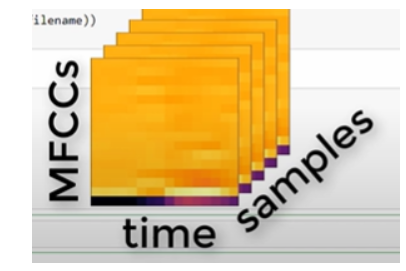

The first dim is the number of the data samples in the dataset. The second dim is the mfcc and the third is the number of sets in the coefficients

In [34]:
# Look at tensor dimensions
print(x_train.shape)
print(x_val.shape)
print(x_test.shape)

(14743, 16, 16)
(1847, 16, 16)
(1884, 16, 16)


In [35]:
# View the dimensions of our input data
print(x_train.shape)

(14743, 16, 16)


# Understanding CNN
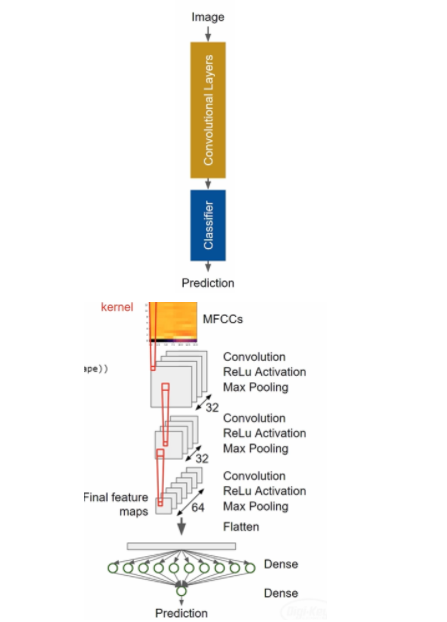

In [36]:
# CNN for TF expects (batch, height, width, channels)
# So we reshape the input tensors with a "color" channel of 1
x_train = x_train.reshape(x_train.shape[0], 
                          x_train.shape[1], 
                          x_train.shape[2], 
                          1)
x_val = x_val.reshape(x_val.shape[0], 
                      x_val.shape[1], 
                      x_val.shape[2], 
                      1)
x_test = x_test.reshape(x_test.shape[0], 
                        x_test.shape[1], 
                        x_test.shape[2], 
                        1)
print(x_train.shape)
print(x_val.shape)
print(x_test.shape)

(14743, 16, 16, 1)
(1847, 16, 16, 1)
(1884, 16, 16, 1)


dim=16. Tensorflow excepts the input tensors in a 4D as input to CNN. Specifically it want sample number, height, wdth, channel



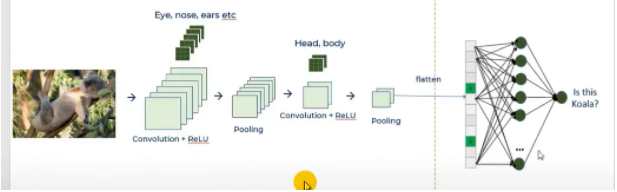

In [37]:
# Input shape for CNN is size of MFCC of 1 sample
sample_shape = x_test.shape[1:]
print(sample_shape)
# 1 because only 1 matrix of 16*16

(16, 16, 1)


In [38]:
# Build model
# Based on: https://www.geeksforgeeks.org/python-image-classification-using-keras/
model = models.Sequential()

#conv2d: reduce shape by 1 , reduce boundary
# number of neurons =32
# frame window=(2,2)
# activation= relu so that we have positive value
# input shape= tells the shape ofinput.
model.add(layers.Conv2D(48,(2, 2), activation='tanh',input_shape=sample_shape))
# shape reduction 
model.add(layers.MaxPooling2D(pool_size=(2, 2)))

#hidden layer 1
model.add(layers.Conv2D(48, (2, 2), activation='tanh'))
model.add(layers.MaxPooling2D(pool_size=(2, 2)))

#hidden layer 2
model.add(layers.Conv2D(72, (2, 2), activation='tanh'))
model.add(layers.MaxPooling2D(pool_size=(2, 2)))

# Classifier
model.add(layers.Flatten())
#convert data to 1D so that next layer process will have small dim

model.add(layers.Dense(64, activation='relu'))

model.add(layers.Dropout(0.5))
#ignore random samples

model.add(layers.Dense(len(dict), activation='softmax'))
#output layer

In [39]:
# Display model
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 15, 15, 48)        240       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 7, 7, 48)         0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 6, 6, 48)          9264      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 3, 3, 48)         0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 2, 2, 72)          13896     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 1, 1, 72)         0

In [40]:
# Add training hyperparameters to model
model.compile(loss='sparse_categorical_crossentropy', 
              optimizer='adam', 
              metrics=['acc'])

 #finding error,  devieation in the learning process             
#optimize the input weights by comparing the prediction and the loss function
#valuate the performance of  model

In [41]:
# Train
history = model.fit(x_train, 
                    y_train, 
                    epochs=30,
                    batch_size=150, 
                    validation_data=(x_val, y_val))

Epoch 1/30
99/99 [==============================] - 7s 49ms/step - loss: 3.0751 - acc: 0.0908 - val_loss: 2.6831 - val_acc: 0.2355
Epoch 2/30
99/99 [==============================] - 5s 55ms/step - loss: 2.4809 - acc: 0.2350 - val_loss: 2.0736 - val_acc: 0.3844
Epoch 3/30
99/99 [==============================] - 7s 75ms/step - loss: 2.0586 - acc: 0.3558 - val_loss: 1.7605 - val_acc: 0.4949
Epoch 4/30
99/99 [==============================] - 7s 69ms/step - loss: 1.7903 - acc: 0.4411 - val_loss: 1.5081 - val_acc: 0.5717
Epoch 5/30
99/99 [==============================] - 6s 58ms/step - loss: 1.5938 - acc: 0.5076 - val_loss: 1.3386 - val_acc: 0.6107
Epoch 6/30
99/99 [==============================] - 5s 55ms/step - loss: 1.4143 - acc: 0.5662 - val_loss: 1.2227 - val_acc: 0.6340
Epoch 7/30
99/99 [==============================] - 5s 53ms/step - loss: 1.3005 - acc: 0.6067 - val_loss: 1.1141 - val_acc: 0.6822
Epoch 8/30
99/99 [==============================] - 5s 54ms/step - loss: 1.2032 - a

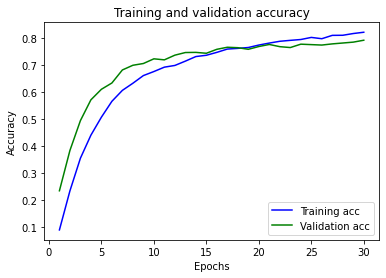

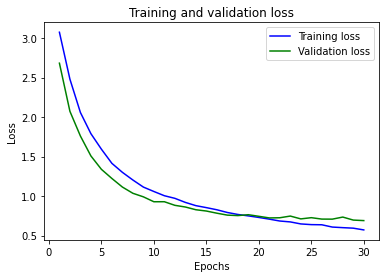

In [42]:
# Plot results

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'b', label='Training acc')
plt.plot(epochs, val_acc, 'g', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'g', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.show()

In [43]:
# Save the model as a file
models.save_model(model, model_filename)

In [44]:
# TEST: Load model and run it against test set
model = models.load_model(model_filename)
for i in range(15, 20):
    #?????????????????????expand extra dimensions(adding channel). value:0
    print('Answer:', y_test[i], ' Prediction:', model.predict(np.expand_dims(x_test[i], 0)))
    print()

Answer: 2.0  Prediction: [[4.1117832e-02 4.3163527e-04 9.5616329e-01 2.4390985e-07 1.1952331e-03
  3.1669544e-05 1.8784088e-10 3.2562291e-09 1.1673813e-04 4.6328752e-04
  5.7754651e-10 4.1332218e-04 1.8910691e-07 8.8253455e-07 2.2260356e-06
  1.1996815e-08 1.4489503e-05 4.1067665e-07 5.4379384e-10 1.8982824e-05
  6.1060852e-08 3.8469075e-10 6.0246799e-07 1.3127348e-10 1.9460999e-10
  2.6145557e-05 2.3840651e-07 2.5745619e-06 4.7225043e-08 3.0144505e-09]]

Answer: 1.0  Prediction: [[1.4285757e-02 9.0180981e-01 3.8434763e-02 7.9840998e-04 1.7387248e-03
  1.4961718e-02 1.6386035e-07 1.1263594e-06 1.8535628e-05 1.2090321e-04
  1.3700428e-06 4.0299650e-03 2.3743892e-04 5.3015037e-06 6.6888276e-03
  2.9128865e-05 5.0275363e-03 3.7365553e-05 1.5287007e-06 5.1439931e-03
  1.5980967e-03 1.1948980e-05 9.9591598e-05 1.2217185e-07 2.0951040e-07
  4.7983194e-04 6.4359605e-04 6.0072244e-04 3.1921722e-03 1.2503563e-06]]

Answer: 16.0  Prediction: [[5.8287128e-07 4.7051253e-07 6.7293790e-06 1.5183747e

In [45]:
# Evaluate model with test set
model.evaluate(x=x_test, y=y_test)

59/59 [==============================] - 1s 6ms/step - loss: 0.6225 - acc: 0.8063


[0.6224886178970337, 0.806263267993927]

In [46]:
ytesting = [0]

In [49]:
try:
    xtesting = calc_mfcc('testing data\\shan_wow_how.wav')
    answer = model.predict(np.expand_dims(xtesting,0))
   
except FileNotFoundError:
    print("Incorrect file name. Please try again")
    
except :  
    print("Please speak/record the complete word")

Please speak/record the complete word


In [48]:
 if(len(answer)==0):
        print("Recording Error! Please record again")
else:
    per_ans=[]
    for x in range(len(answer[0])):
            per_ans.append( float("%.4f" % (answer[0][x]))*100)

    r=max(per_ans)
    if r<60:
        print("word was not spoken correctly!! please try aagin")

    else:
        print(dict[per_ans.index(max(per_ans))]," was said correctly. Well Done.")


NameError: name 'answer' is not defined

In [ ]:
per_ans

In [ ]:
dict


In [ ]:
try:
    xtesting = calc_mfcc('testing data\\shan_two.wav')
    
except FileNotFoundError:
    print("Incorrect file name. Please try again")
try:
    answer = model.predict(np.expand_dims(xtesting,0))
    if (len(answer)==0):
        raise
except:
    print("Recording Error")

In [ ]:
per_ans=[]
for x in range(len(answer[0])):
        per_ans.append( float("%.4f" % (answer[0][x]))*100)

r=max(per_ans)
if r<60:
    print("word was not spoken correctly!! please try aagin")
else:
    print(dict[per_ans.index(max(per_ans))]," was said correctly. Well Done.")
    